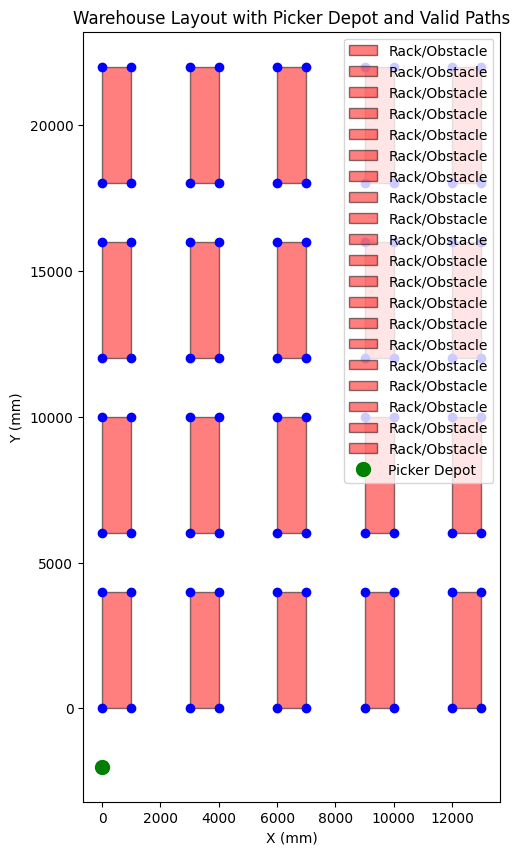

In [1]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt


def generate_racks(rows, cols, rack_width=1000, rack_height=4000, walkway_width=2000):
    """
    Generates rack polygons and vertices for a traditional warehouse layout.
    :param rows: Number of rows of racks
    :param cols: Number of columns of racks
    :param rack_width: Width of each rack in mm
    :param rack_height: Height of each rack in mm
    :param walkway_width: Width of walkways between racks in mm
    :return: (list of rack polygons, list of vertices)
    """
    rack_polygons = []
    vertices = []

    for row in range(rows):
        for col in range(cols):
            # Bottom-left corner of the rack
            x_start = col * (rack_width + walkway_width)
            y_start = row * (rack_height + walkway_width)

            # Create a polygon for the rack
            rack_polygon = Polygon([
                (x_start, y_start),  # Bottom-left
                (x_start, y_start + rack_height),  # Top-left
                (x_start + rack_width, y_start + rack_height),  # Top-right
                (x_start + rack_width, y_start)  # Bottom-right
            ])
            rack_polygons.append(rack_polygon)

            # Add vertices (corners of the rack)
            vertices.extend([
                (x_start, y_start),
                (x_start, y_start + rack_height),
                (x_start + rack_width, y_start + rack_height),
                (x_start + rack_width, y_start)
            ])

    return rack_polygons, vertices


def add_picker_depot(vertices, depot_x=0, depot_y=-2000):
    """
    Adds the picker depot to the vertices.
    :param vertices: List of (x, y) vertices
    :param depot_x: X-coordinate of the depot
    :param depot_y: Y-coordinate of the depot
    :return: Updated list of vertices
    """
    depot = (depot_x, depot_y)
    vertices.append(depot)
    return vertices, depot

def generate_adjacency_matrix(vertices, polygons):
    """
    Generates the adjacency matrix for vertices with polygons as obstacles.
    :param vertices: List of (x, y) coordinates representing vertices
    :param polygons: List of polygons representing obstacles
    :return: N-by-N binary adjacency matrix
    """
    N = len(vertices)
    adjMat = np.ones((N, N), dtype=int)  # Start with all connections allowed

    for i in range(N):
        for j in range(i + 1, N):  # Check pairs of vertices
            if i != j:
                line = LineString([vertices[i], vertices[j]])  # Line segment

                # Check if the line intersects any polygon
                for poly in polygons:
                    if line.intersects(poly):
                        adjMat[i, j] = 0  # Block the connection
                        adjMat[j, i] = 0  # Symmetry
                        break

    return adjMat

def visualize_layout(vertices, polygons, adjMat, depot):
    """
    Visualizes the rack layout, picker depot, and valid edges.
    :param vertices: List of vertices
    :param polygons: List of polygons (racks and obstacles)
    :param adjMat: Adjacency matrix
    :param depot: Coordinates of the picker depot
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot rack polygons
    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='red', ec='black', label='Rack/Obstacle')

    # Plot vertices
    for vertex in vertices:
        if vertex == depot:
            ax.plot(vertex[0], vertex[1], 'go', markersize=10, label='Picker Depot')  # Green for depot
        else:
            ax.plot(vertex[0], vertex[1], 'bo')  # Blue for regular vertices

    # Plot edges based on adjacency matrix
    N = len(vertices)
    for i in range(N):
        for j in range(i + 1, N):
            if adjMat[i, j] == 1:
                x_coords = [vertices[i][0], vertices[j][0]]
                y_coords = [vertices[i][1], vertices[j][1]]
                ax.plot(x_coords, y_coords, 'g-')  # Valid edge

    plt.title("Warehouse Layout with Picker Depot and Valid Paths")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.legend(loc='upper right')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Define layout parameters
rows = 4
cols = 5
rack_width = 1000
rack_height = 4000
walkway_width = 2000

# Generate rack polygons and vertices
rack_polygons, vertices = generate_racks(rows, cols, rack_width, rack_height, walkway_width)

# Add picker depot
vertices, depot = add_picker_depot(vertices)

# Generate adjacency matrix
adjMat = generate_adjacency_matrix(vertices, rack_polygons)

# Visualize the layout
visualize_layout(vertices, rack_polygons, adjMat, depot)




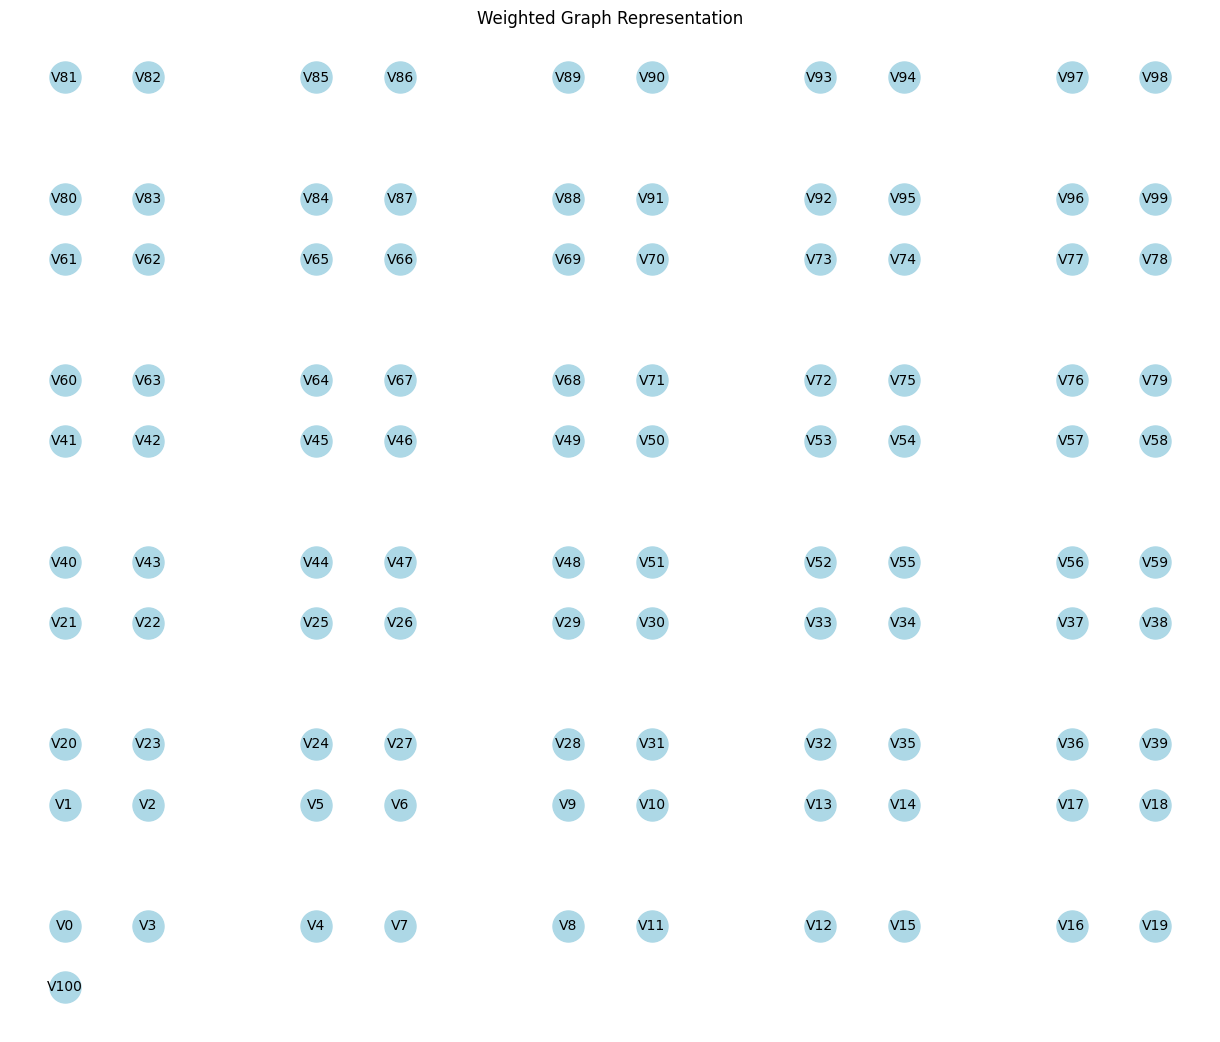

In [4]:
def generate_weighted_adjacency_matrix(vertices, adjMat):
    """
    Generates the weighted adjacency matrix based on Euclidean distance.
    :param vertices: List of (x, y) coordinates representing vertices
    :param adjMat: Adjacency matrix
    :return: N-by-N weighted adjacency matrix
    """
    N = len(vertices)
    weightedAdjMat = np.zeros((N, N))  # Initialize with zeros

    for i in range(N):
        for j in range(i + 1, N):  # Iterate through upper triangular matrix
            if adjMat[i, j] == 1:  # If connected
                # Compute Euclidean distance (L2 norm)
                distance = np.sqrt((vertices[i][0] - vertices[j][0])**2 + (vertices[i][1] - vertices[j][1])**2)
                weightedAdjMat[i, j] = distance
                weightedAdjMat[j, i] = distance  # Symmetric matrix
            else:
                # Assign a high value (∞) for disconnected vertices
                weightedAdjMat[i, j] = np.inf
                weightedAdjMat[j, i] = np.inf

    return weightedAdjMat

import networkx as nx

def construct_weighted_graph(vertices, weightedAdjMat):
    """
    Constructs a weighted graph using NetworkX.
    :param vertices: List of (x, y) coordinates representing vertices
    :param weightedAdjMat: Weighted adjacency matrix
    :return: NetworkX weighted graph
    """
    G = nx.Graph()  # Initialize graph

    # Add vertices
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)  # Add vertex with its position as an attribute

    # Add edges with weights
    N = len(vertices)
    for i in range(N):
        for j in range(i + 1, N):
            if np.isfinite(weightedAdjMat[i, j]):  # Add edge only if weight is finite
                G.add_edge(i, j, weight=weightedAdjMat[i, j])

    return G

def visualize_weighted_graph(G, vertices):
    """
    Visualizes the weighted graph with vertices and edges.
    :param G: NetworkX graph
    :param vertices: List of vertices
    """
    pos = nx.get_node_attributes(G, 'pos')  # Retrieve positions for nodes
    labels = {i: f"V{i}" for i in range(len(vertices))}  # Create labels for nodes
    edge_labels = nx.get_edge_attributes(G, 'weight')  # Retrieve edge weights

    # Draw the graph
    plt.figure(figsize=(12, 10))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)})
    plt.title("Weighted Graph Representation")
    plt.show()
    
    # Define layout parameters
rows = 5
cols = 5
rack_width = 1000
rack_height = 4000
walkway_width = 2000

# Generate rack polygons and vertices
rack_polygons, vertices = generate_racks(rows, cols, rack_width, rack_height, walkway_width)

# Add picker depot
vertices, depot = add_picker_depot(vertices)

# Generate adjacency matrix
adjMat = generate_adjacency_matrix(vertices, rack_polygons)

# Generate weighted adjacency matrix
weightedAdjMat = generate_weighted_adjacency_matrix(vertices, adjMat)

# Construct the weighted graph
G = construct_weighted_graph(vertices, weightedAdjMat)

# Visualize the weighted graph
visualize_weighted_graph(G, vertices)


In [5]:
import networkx as nx

def rank_storage_locations_by_distance(G, depot_index):
    """
    Ranks storage locations by shortest distance from the depot.
    :param G: NetworkX weighted graph
    :param depot_index: Index of the depot in the graph
    :return: List of (node, distance) tuples sorted by distance
    """
    # Compute shortest paths from the depot
    shortest_paths = nx.single_source_dijkstra_path_length(G, source=depot_index, weight='weight')

    # Sort by distance
    ranked_locations = sorted(shortest_paths.items(), key=lambda x: x[1])

    return ranked_locations

# Rank storage locations by distance from the depot
depot_index = len(vertices) - 1  # Assuming depot is the last vertex
ranked_locations = rank_storage_locations_by_distance(G, depot_index)

print("Storage locations ranked by distance from the depot:")
for node, distance in ranked_locations:
    print(f"Location V{node}: Distance = {distance:.2f} mm")


Storage locations ranked by distance from the depot:
Location V100: Distance = 0.00 mm
